In [6]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [7]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [8]:
import netCDF4 as nc
import sys
sys.path.append('/data/tjarniko/mocsy')
import mocsy
import numpy as np

import gsw
import arrow
import glob
import cmocean as cm
import matplotlib.pyplot as plt

from salishsea_tools import (
    nc_tools,
    viz_tools,
    geo_tools,
    tidetools
)

%matplotlib inline

## Purpose of notebook

Here I'm going to first plot your stations on a map, and then take the timeseries of DIC, TA, temp, and salinity that we've built in part B and calculate pH and $\Omega_A$ from it and visualise those as a timeseries. The python package I use for this is called [mocsy](http://ocmip5.ipsl.jussieu.fr/mocsy/), and it's relatively fancy - and installing it on your own computer can be a bit of a pain. If you have access to the Waterhole cluster, you can just use the path to the installation that I listed above. Below I've written a wrapper code for it (oned_moxy). 




#### TJSJ let's make a dict with placenames, colors, and then code a map to visualise the stations

In [9]:
PLACES = {
'Deep Bay': {
    
'lon lat': (-124.7392, 49.4606),

'color': 'red', 'NEMO grid ji': (599, 126),

},

'Southern Baynes': {

'lon lat': (-124.7457, 49.4760),

'color': 'sienna', 'NEMO grid ji': (602, 127),

},

'Northern Baynes': {

'lon lat': (-124.8924, 49.6492),

'color': 'orange', 'NEMO grid ji': (646, 127),

},

'Fanny Bay': {

'lon lat': (-124.8227, 49.5086),

'color': 'gold', 'NEMO grid ji': (614, 120),

},

'Maple Bay': {

'lon lat': (-123.5947, 48.8140),

'color': 'olivedrab', 'NEMO grid ji': (392, 213),

},

'Salt Spring': {

'lon lat': (-123.5513, 48.7993),

'color': 'lightgreen', 'NEMO grid ji': (386, 218),

},

'Nanoose Bay': {

'lon lat': (-124.1359, 49.2609),

'color': 'turquoise', 'NEMO grid ji': (517, 190),

},

'Lasqueti Island': {

# deg E, deg N

'lon lat': (-124.3384, 49.5442),

'color': 'dodgerblue', 'NEMO grid ji': (586, 195),

},

'Main SoG': {

'lon lat': (-123.5832, 49.1177),

'color': 'slategray', 'NEMO grid ji': (450, 253),

},

'Cortes/Marina': {

'lon lat': (-125.0194, 50.0418),

'color': 'royalblue', 'NEMO grid ji': (732, 157),

},

'Lund/Desolation Sound': {

'lon lat': (-124.7666, 49.9804),

'color': 'darkviolet', 'NEMO grid ji': (702, 187),

},

'Mouth of Okeover': {

'lon lat': (-124.8174, 50.0805),

'color': 'pink', 'NEMO grid ji': (726, 192),

},
}

list_places = ['Deep Bay', 'Southern Baynes', 'Northern Baynes', \
               'Fanny Bay', 'Maple Bay', 'Salt Spring', 'Nanoose Bay',\
               'Lasqueti Island', 'Main SoG', 'Cortes/Marina', \
               'Lund/Desolation Sound', 'Mouth of Okeover']

#### map plotting code

/home/tjarniko/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:531: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


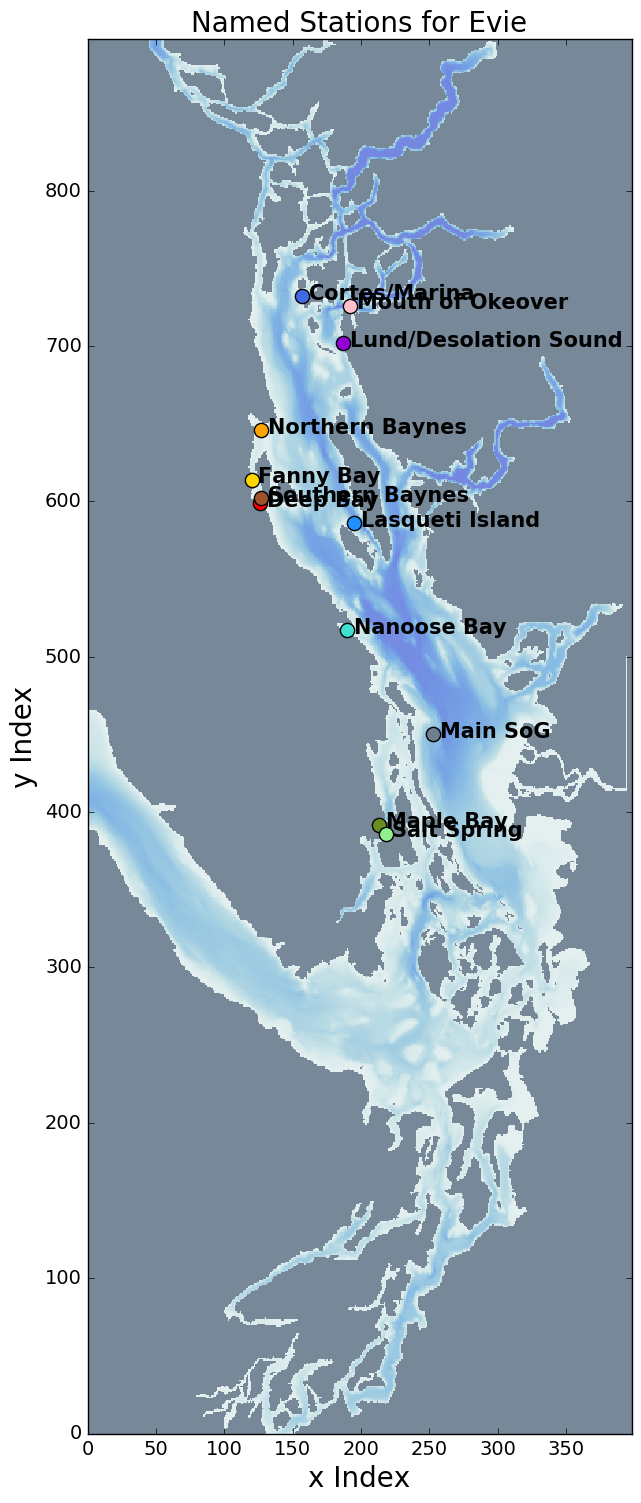

In [10]:
bath = nc.Dataset('/data/tjarniko/MEOPAR/grid/bathymetry_201702.nc')
bath1 = bath.variables['Bathymetry']

def wshed_plot(surfdat_1,tit1,t_cmap,xsize,ysize,v_min1,v_max1,cl1,bigtit):

    fig, ax = plt.subplots(1, 1, figsize=(xsize, ysize), sharey=True)
    cmap = t_cmap
            

    tplt = np.ma.masked_values(surfdat_1,0)
    ax.set_title(tit1,fontsize = 20 )
    v_min = v_min1
    v_max = v_max1
    clabel = cl1

    viz_tools.set_aspect(ax)
    mesh = ax.pcolormesh(tplt, cmap=t_cmap, vmin=v_min, vmax=v_max) 
    ax.set_xlabel('x Index', fontsize = 20 )
    ax.set_ylabel('y Index', fontsize = 20 )
    
    for i in range(0,len(list_places)):
        t_place = list_places[i]
        tj = PLACES[t_place]['NEMO grid ji'][1]
        ti = PLACES[t_place]['NEMO grid ji'][0]
        col = PLACES[t_place]['color']
        pts = ax.scatter(tj,ti,s=105,c=col,marker='o')
        ax.text(tj+5,ti-2,t_place, weight = 'bold', fontsize = 15)

    plt.xlim([0,398])
    plt.ylim([0,898])
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    cmap.set_bad('lightslategray')
    plt.legend(bbox_to_anchor=(1.29, 0.95))
    plt.suptitle(bigtit,fontsize=20)
    
fact = 0.6
wshed_plot(bath1,'Named Stations for Evie', \
               cm.cm.dense,20*fact,30*fact,0,1000,'bathymetry','')

#### TJSJ wrapper code for mocsy

In [11]:
def oned_moxy(tsal, ttemp, tdic, tta, pres_atm, depth_this):

    size_box = np.shape(tdic)
    size_0 = size_box[0]
    size_1= size_box[1]

    tsra = np.ravel(tsal)
    ttera = np.ravel(ttemp)
    ttara = np.ravel(tta) * 1e-3
    tdra = np.ravel(tdic) * 1e-3
    tzero = np.zeros_like(tsra)
    tpressure = np.zeros_like(tsra)
    tdepth = np.zeros_like(tsra)
    tdepth[:] = depth_this
     
    tpressure[:] = pres_atm
    tzero = tpressure * 0 
        
    tsra_psu = tsra*35/35.16504
    ttera_is = gsw.t_from_CT(tsra,ttera,tzero)

    response_tup = mocsy.mvars(temp=ttera_is, sal=tsra_psu, alk=ttara, dic=tdra, 
                       sil=tzero, phos=tzero, patm=tpressure, depth=tdepth, lat=tzero, 
                        optcon='mol/m3', optt='Tinsitu', optp='m',
                        optb = 'l10', optk1k2='m10', optkf = 'dg', optgas = 'Pinsitu')
    pH,pco2,fco2,co2,hco3,co3,OmegaA,OmegaC,BetaD,DENis,p,Tis = response_tup

    pHr = pH.reshape(size_0,size_1)
    OmAr = OmegaA.reshape(size_0,size_1)
    pco2r = pco2.reshape(size_0,size_1)
    
    return pHr, OmAr, pco2r

#### TJSJ let's make a dict in which to store the OmA and pH timeseries

In [12]:
PLACES_withdat = {
'Deep Bay': {
'NEMO grid ji': (599, 126),
    'OmA_timeseries':np.zeros([3,365]),
    'pH_timeseries':np.zeros([3,365])

},
    
'Southern Baynes': {
'NEMO grid ji': (602, 127),
    'OmA_timeseries':np.zeros([3,365]),
    'pH_timeseries':np.zeros([3,365])
},

'Northern Baynes': {
'NEMO grid ji': (646, 127),
    'OmA_timeseries':np.zeros([3,365]),
    'pH_timeseries':np.zeros([3,365])},

'Fanny Bay': {
'NEMO grid ji': (614, 120),
    'OmA_timeseries':np.zeros([3,365]),
    'pH_timeseries':np.zeros([3,365])},

'Maple Bay': {
'NEMO grid ji': (392, 213),
    'OmA_timeseries':np.zeros([3,365]),
    'pH_timeseries':np.zeros([3,365])
},

'Salt Spring': {
'NEMO grid ji': (386, 218),
    'OmA_timeseries':np.zeros([3,365]),
    'pH_timeseries':np.zeros([3,365])
},

'Nanoose Bay': {
'NEMO grid ji': (517, 190),
    'OmA_timeseries':np.zeros([3,365]),
    'pH_timeseries':np.zeros([3,365])
},

'Lasqueti Island': {
'NEMO grid ji': (586, 195),
    'OmA_timeseries':np.zeros([3,365]),
    'pH_timeseries':np.zeros([3,365])
},

'Main SoG': {
'NEMO grid ji': (450, 253),
    'OmA_timeseries':np.zeros([3,365]),
    'pH_timeseries':np.zeros([3,365])

},

'Cortes/Marina': {
'NEMO grid ji': (732, 157),
    'OmA_timeseries':np.zeros([3,365]),
    'pH_timeseries':np.zeros([3,365])},

'Lund/Desolation Sound': {
'NEMO grid ji': (702, 187),
    'OmA_timeseries':np.zeros([3,365]),
    'pH_timeseries':np.zeros([3,365])},

'Mouth of Okeover': {
'NEMO grid ji': (726, 192),
    'OmA_timeseries':np.zeros([3,365]),
    'pH_timeseries':np.zeros([3,365])},

}

list_places = ['Deep Bay', 'Southern Baynes', 'Northern Baynes', \
               'Fanny Bay', 'Maple Bay', 'Salt Spring', 'Nanoose Bay',\
               'Lasqueti Island', 'Main SoG', 'Cortes/Marina', \
               'Lund/Desolation Sound', 'Mouth of Okeover']


#### TJSJ let's open the .nc we made in part B, extract the DIC, TA, S, T, variables and run mocsy on them to get pH and Omega A, then store these in the dictionary we just made

In [13]:
t_nc = nc.Dataset('year_timeseries_13jun13.nc')

In [14]:
for i in range(0,len(list_places)):
    stn = list_places[i]

    DIC = t_nc[stn]['DIC_timeseries'][:,:]
    TA = t_nc[stn]['TA_timeseries'][:,:]
    TEMP = t_nc[stn]['T_timeseries'][:,:]
    SAL = t_nc[stn]['S_timeseries'][:,:]

    pHr, OmAr, pco2r =oned_moxy(SAL, TEMP, DIC, TA, 1, 0)

    PLACES_withdat[stn]['OmA_timeseries'] = OmAr
    PLACES_withdat[stn]['pH_timeseries'] = pHr


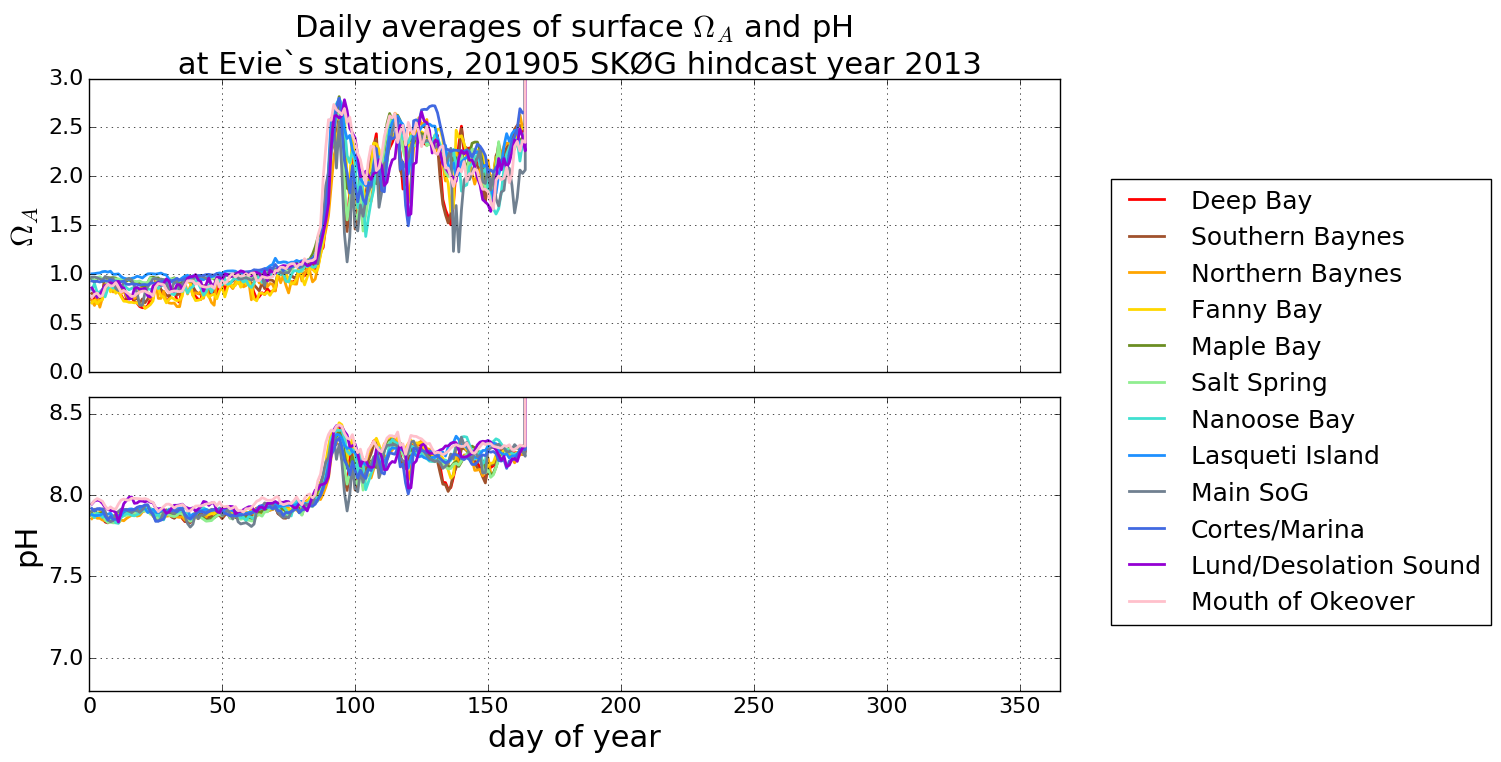

In [15]:
fact = 0.9
mons = np.arange(1,366,1)
fig = plt.figure(figsize=(12*fact,8.5*fact))

ax1 = fig.add_subplot(2,1,1)
for i in range(0,len(list_places)):
    stn = list_places[i]
    ax1.plot(mons,PLACES_withdat[stn]['OmA_timeseries'][0,:], \
             color = PLACES[stn]['color'], linewidth = 2, label = stn)
    ax1.set_ylim([0,3])
    ax1.set_xlim([0,365])
    ax1.set_xticklabels([])
    ax1.set_ylabel('$\Omega_A$', fontsize = 22)
    
    
plt.legend(bbox_to_anchor=(1.04,0.7), loc="upper left", fontsize = 18)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.grid()
plt.title('Daily averages of surface $\Omega_A$ and pH \n at Evie`s stations, 201905 SKØG hindcast year 2013', fontsize = 22)


ax2 = fig.add_subplot(2,1,2)
for i in range(0,len(list_places)):
    stn = list_places[i]
    ax2.plot(mons,PLACES_withdat[stn]['pH_timeseries'][0,:], color = PLACES[stn]['color'], linewidth = 2 )
    ax2.set_ylim([6.8,8.6])
    ax2.set_xlim([0,365])
    ax2.set_ylabel('pH', fontsize = 22)
    ax2.set_xlabel('day of year', fontsize = 22)

plt.grid()
plt.tight_layout()

plt.tick_params(axis='both', which='major', labelsize=16)
